# **Modelo v1 | Decision Tree - Classificação de texto do usuário**

## **Link do Projeto no Colab**
---

https://colab.research.google.com/drive/1_lyl_ZuoteHaTbjHk_wadnHUzhgmYk8R?usp=sharing

## **Introdução**
---

A classificação de texto é uma tarefa fundamental no processamento de linguagem natural, que visa categorizar automaticamente documentos de texto em diferentes classes ou categorias. Essa técnica permite extrair insights valiosos de grandes volumes de dados não estruturados, como sentimentos, tópicos ou intenções expressas nos textos. Com o avanço das tecnologias de aprendizado de máquina e a disponibilidade de conjuntos de dados cada vez mais robustos, a classificação de texto tornou-se uma ferramenta poderosa para a análise e organização de informações, encontrando aplicações em áreas como análise de sentimentos, filtragem de spam, detecção de notícias falsas e muito mais.

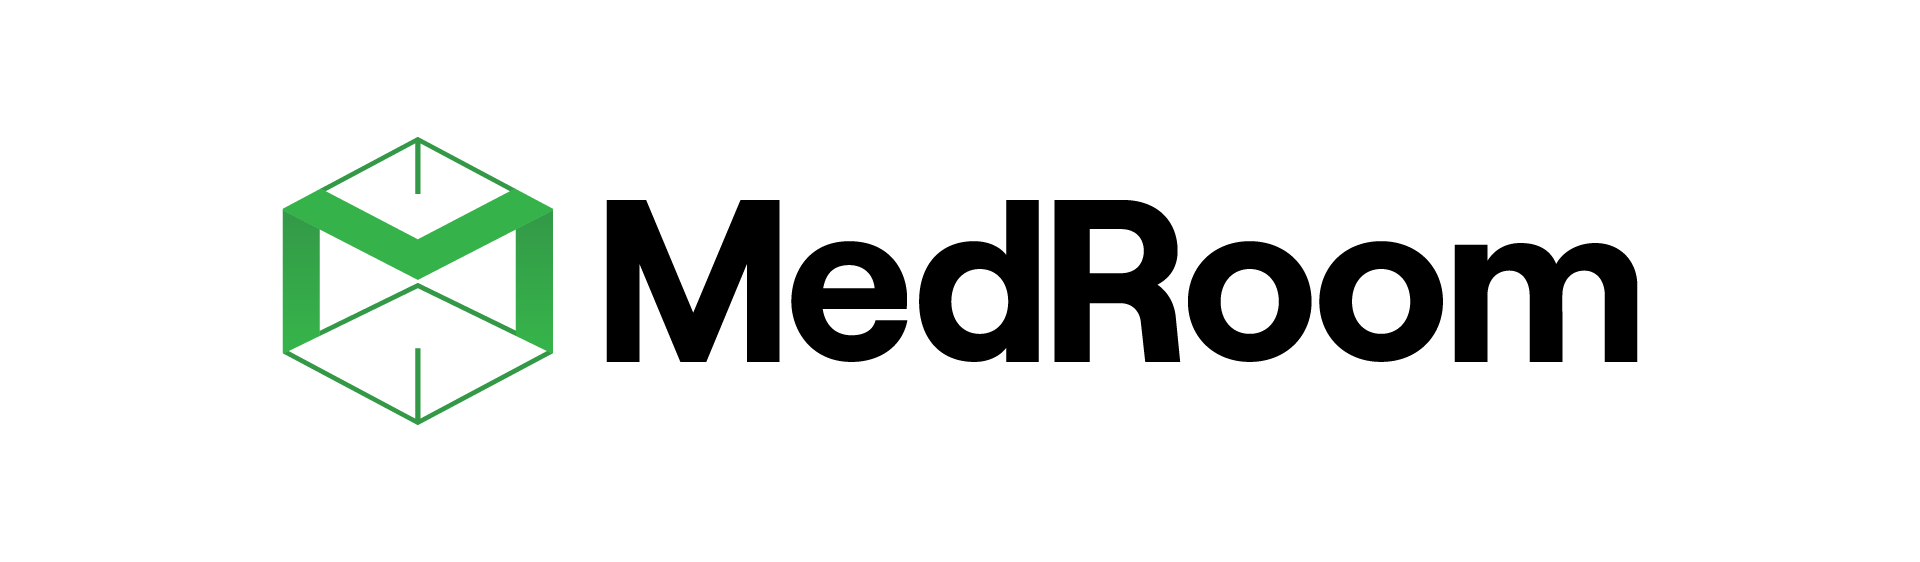

Neste projeto, faremos uso de um conjunto de dados pré-processados composto por interações de usuários com o paciente virtual Simplício, essas interações foram rotuladas pelo ChatGPT com as seguintes classes: Boas-vindas, Comando, Investigação, Orientação e Término da consulta. Empregaremos técnicas de pré-processamento de texto e treinaremos um modelo de classificação de texto utilizando um algoritmo chamado Decision Tree.

## **Sobre os dados**
---

Neste estudo, estaremos utilizando dados obtidos de diálogos entre pessoas reais e nosso modelo de inteligência artificial (Simplício) + Rotulagem feita pelo ChatGPT.

Tudo foi compilado em um único arquivo e no final temos duas colunas:
- **x_treino:** Texto do usuário/pessoas reais
- **y_treino:** Classe rotulada pelo ChatGPT

## **Objetivo**
---

Com base nas informações dispostas nesse conjunto de dados, temos como objetivo:
- Criar um modelo de classificação de texto das interações dos usuários

<img src="https://media.giphy.com/media/dQpUkK59l5Imxsh8jN/giphy.gif" alt="win" width="600"/>

## **Preparação dos dados**
---

### **Libs**
---

Primeiro, vamos importar as bibliotecas necessárias:

In [ ]:
import warnings # Ignorar avisos
warnings.filterwarnings('ignore')
import pandas as pd # Manipulação de dados
import numpy as np # Manipulação de arrays
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
import string # Manipulação de strings
!pip install unidecode
from unidecode import unidecode # Remover acentos
from sklearn.model_selection import train_test_split, GridSearchCV # Divisão treino e teste / Busca em grade
from sklearn.feature_extraction.text import TfidfVectorizer # Vetorização
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn import preprocessing # Pré-processamento de dados
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score # Métricas de avaliação

### **DataFrame**
---

Em seguida, carregar o DataFrame com os dados:

In [2]:
# Importando dados
df = pd.read_excel('analise_exploratoria.xlsx')
df.head()

,Unnamed: 0,x_treino,y_treino
0,0,oi oi simples tudo bem,Boas-vindas
1,1,foi simples tudo bem,Boas-vindas
2,2,bom dia,Boas-vindas
3,3,oi simplicio como e que voce esta,Boas-vindas
4,4,oi querido esta tudo bem,Boas-vindas


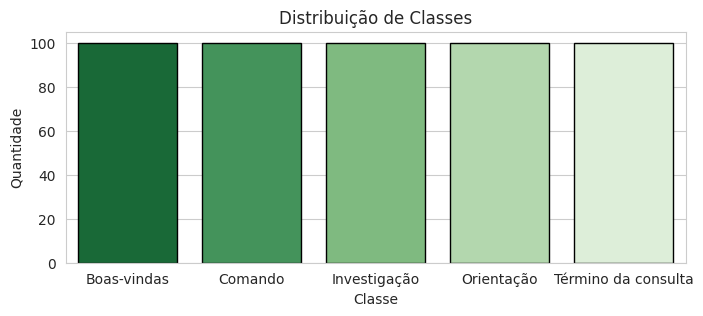

In [3]:
# Distribuição de Classes
sns.set_style('whitegrid')
plt.figure(figsize=(8, 3))
sns.countplot(x='y_treino', data=df, palette='Greens_r',edgecolor='black');
plt.title("Distribuição de Classes");
plt.xlabel("Classe");
plt.ylabel("Quantidade");

Como podemos notar no gráfico de distribuição, temos 100 entradas para cada classe e nosso conjunto de dados está balanceado.

### **Divisão treino e teste**
---

Vamos dividir os dados em conjuntos de treino e teste. Neste exemplo, usaremos 80% dos dados para treino e 20% para teste:

In [4]:
def div_treino_teste(DataFrame):
  # Extraindo valores das colunas
  X = DataFrame['x_treino'].values # Dados de entrada
  y = DataFrame['y_treino'].values # Alvo

  # Dividindo nosso conjunto de dados em treino e teste. O parâmetro 'test_size' define a proporção do conjunto de teste (20% neste caso)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      shuffle=True,
                                                      test_size = 0.20,
                                                      random_state=1)
  # Retorno da função
  return X, y, X_train, X_test, y_train, y_test

In [5]:
# Criando variáveis e passando nosso DataFrame para divisão treino e teste
X, y, X_train, X_test, y_train, y_test = div_treino_teste(df)

# Tamanho após divisão
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400,), (100,), (400,), (100,))

### **Vetorização de texto | TF-IDF**
---

A vetorização de texto é um processo fundamental em tarefas de processamento de linguagem natural (NLP) e análise de texto. Ela consiste em converter textos em representações numéricas (vetores) que possam ser processadas por algoritmos de aprendizado de máquina.

O TF-IDF leva em consideração a frequência de termos no documento (TF) e a raridade do termo no conjunto de documentos (IDF). Ele atribui maior peso a palavras que ocorrem com mais frequência no documento e raramente ocorrem em outros documentos.

O TfidfVectorizer é útil quando você deseja atribuir mais importância a palavras menos frequentes, mas com significado informativo, enquanto diminui a importância de palavras muito frequentes, como artigos e preposições.

In [6]:
# Criar um vetorizador para converter o texto em recursos numéricos (usando TF-IDF)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train) # Dados de treino
X_test = vectorizer.transform(X_test) # Dados de teste

## **Modelo Decision Tree v1.0**
---

A Árvore de Decisão é um modelo de aprendizado de máquina que utiliza uma estrutura em forma de árvore para tomar decisões com base em condições sobre as características dos dados. Cada nó interno da árvore representa uma condição, cada ramo representa uma possível resposta para essa condição, e cada folha representa uma decisão final. Esse modelo é utilizado tanto para problemas de classificação, onde as amostras são divididas em classes, quanto para problemas de regressão, onde são previstos valores numéricos. A Árvore de Decisão é valorizada pela sua interpretabilidade e facilidade de compreensão, sendo uma ferramenta importante para explicar as decisões tomadas pelo modelo. No entanto, é necessário considerar técnicas de regularização para evitar o overfitting e lidar com problemas complexos que envolvem muitas características.

Vamos criar e treinar nosso primeiro modelo:

In [7]:
# Criar o modelo de classificação com Decision Tree
model = DecisionTreeClassifier(random_state=1)

# Treinamento
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [48]:
# Criar um dataframe a partir dos parâmetros
df_params = pd.DataFrame.from_dict(model.get_params(), orient='index', columns=['Valor'])

# Exibir o dataframe
df_params

,Valor
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


### **Avaliação | Dados de teste**
---

Agora que o modelo foi treinado, vamos avaliá-lo usando os dados de teste:

In [8]:
# Previsões no conjunto de teste
y_pred = model.predict(X_test)

#### **Acurácia**
---

Umas das métricas de avaliação é a "Acurácia", ela diz o quanto o modelo acertou de acordo com as previsões possíveis:

In [9]:
# Acurácia
acc = accuracy_score(y_test,y_pred)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 71%


#### **ROC_AUC**
---

A métrica AUC-ROC (Area Under the Receiver Operating Characteristic Curve) é usada para avaliar o desempenho de modelos de classificação, especialmente em problemas binários ou multiclasse. A AUC-ROC mede a capacidade do modelo de distinguir entre diferentes classes, plotando a taxa de verdadeiros positivos (TPR) em relação à taxa de falsos positivos (FPR) para diferentes limiares de decisão.

Resumidamente, a AUC-ROC oferece as seguintes informações:

- Varia de 0 a 1: A AUC-ROC é uma métrica que varia de 0 a 1. Um valor de 0,5 indica um desempenho equivalente ao acaso, enquanto um valor próximo de 1 indica um modelo com alta capacidade de distinguir corretamente entre as classes.

- Representa a qualidade da classificação: Quanto maior a AUC-ROC, melhor o desempenho do modelo em classificar corretamente as amostras, principalmente em termos de sensibilidade (TPR) e especificidade (1 - FPR).

In [10]:
def roc_auc(y_test,y_pred):
  # Converter rótulos para formato binário
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)

  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)

  # Calcular a área sob a curva (AUC-ROC)
  auc_roc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
  return print("ROC_AUC do modelo = %2.f%%" % (auc_roc *100.00))

In [11]:
# ROC-AUC
roc_auc(y_test,y_pred)

ROC_AUC do modelo = 82%


#### **Relatório de classificação**
---

Dentre as bibliotecas que importamos existe o "relatório de classificação", nele somos apresentados a mais 3 métricas, são elas:

- *Recall/Sensibilidade*: Medida que nos mostra o quão bom o modelo é para prever/detectar positivos
- *Precisão*: Medida que nos ajuda a responder a seguinte pergunta: Dos classificados como positivos, quantos são realmente positivos?
- *f1-score:* Nos mostra o balanço entre a precisão e o recall de nosso modelo, quanto mais próximo de 1 melhor

In [12]:
# Criando relatório de classificação
def relatorio(y_test,y_pred):
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  # Plotagem do relatório de classificação
  plt.subplots(figsize=(4,3))
  sns.heatmap(report_df, cmap='Greens', linewidths=0.5, annot=True);

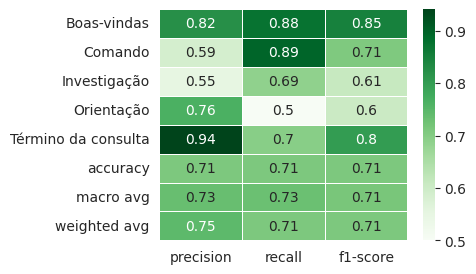

In [13]:
# Plot relatório de classificação
relatorio(y_test,y_pred)

#### **Matriz de confusão**
---

A "matriz de confusão" é uma tabela que mostra as frequências de classificação para cada classe do nosso modelo

In [14]:
def matriz_confusao(y_test,y_pred):

  # Criando a matriz de confusão
  report_df = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)). T
  report_df = report_df.drop(columns=['support'])

  cnf_report_df = report_df.index[:-3]
  cnf_matrix = confusion_matrix(y_test,y_pred)
  cnf_matrix = pd.DataFrame(cnf_matrix, index = cnf_report_df.values, columns = cnf_report_df.values)
  cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:, np.newaxis] # Normalização em linha (recall)

  # Plotagem da matriz de confusão
  sns.heatmap(cnf_matrix, cmap='Greens', linecolor='white', linewidths=0.5,
            annot=True, fmt='.0%', cbar=False, square=True);

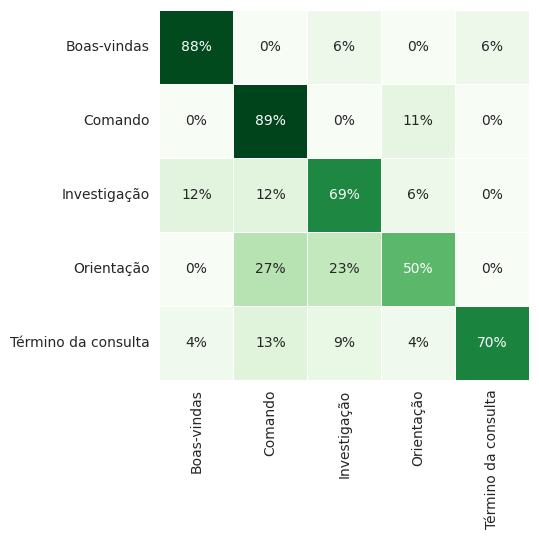

In [15]:
# Plot Matriz de confusão
matriz_confusao(y_test,y_pred)

#### **Resumo**
---

Conclusões após avaliação:
- Acurácia = 71%
- ROC_AUC = 82%
- F1-Score (média ponderada) ficou em 71%

Após avaliação do modelo, podemos dizer que tivemos um resultado razoável (Quase ruim!). O modelo apresentou muitas dificuldades em classificar 'Orientação' (50%) e 'Investigação' (69%).

## **Modelo Decision Tree v1.1**
---

Agora que treinamos nosso primeiro modelo, vamos tentar melhorar os resultados criando um segundo modelo com a otimização de hiperparâmetros:

### **GridSearchCV**
---

Podemos utilizar o GridSearchCV para encontrar os melhores hiperparâmetros.

Dentre os mais importantes, vamos testar os seguintes hiperparâmetros:
- **max_depth**: A profundidade máxima da árvore. Valores maiores permitem árvores mais profundas, mas podem aumentar o risco de overfitting.

- **min_samples_split**: O número mínimo de amostras necessárias para dividir um nó interno. Um valor maior pode ajudar a evitar divisões que resultem em nós com um número muito baixo de amostras.

- **min_samples_leaf**: O número mínimo de amostras necessárias em um nó folha. Um valor maior pode evitar nós folha com um número muito baixo de amostras.

- **max_features**: O número máximo de características a serem consideradas em cada divisão de nó. Reduzir esse número pode ajudar a evitar a sobreposição entre as árvores.

- **criterion**: O critério usado para avaliar a qualidade das divisões. Pode ser "gini" ou "entropy".

- **splitter**: A estratégia usada para escolher a divisão em cada nó. As estratégias suportadas são “melhores” para escolher a melhor divisão e “aleatórias” para escolher a melhor divisão aleatória.

In [49]:
# Definindo os parâmetros para busca
param_grid = {
    'max_depth': [2, 5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2', 5, 10, None],
    'criterion': ['gini','entropy'],
    'splitter': ['best', 'random']
}

# Realizar a busca em grade para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obter os melhores parâmetros encontrados
best_params = grid_search.best_params_

In [50]:
# Treinar o modelo com os melhores parâmetros
model2 = DecisionTreeClassifier(random_state=1, **best_params)
model2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=1)

In [51]:
# Criar um dataframe a partir dos parâmetros
df_params = pd.DataFrame.from_dict(model2.get_params(), orient='index', columns=['Valor'])

# Exibir o dataframe
df_params

,Valor
ccp_alpha,0.0
class_weight,None
criterion,entropy
max_depth,30
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


### **Avaliação 2 | Dados de teste**
---

Realizado o treinamento do nosso modelo com hiperparâmetros, vamos fazer uma segunda avaliação:

In [52]:
# Fazer previsões no conjunto de teste
y_pred = model2.predict(X_test)

#### **Acurácia**
---

In [53]:
# Acurácia
acc = accuracy_score(y_test,y_pred)
print("Acurácia do modelo = %2.f%%" % (acc *100.00))

Acurácia do modelo = 69%


#### **ROC_AUC**
---

In [31]:
# ROC-AUC
roc_auc(y_test,y_pred)

ROC_AUC do modelo = 81%


#### **Relatório de classificação**
---

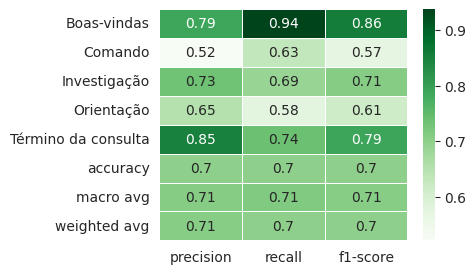

In [32]:
# Plot relatório de classificação
relatorio(y_test,y_pred)

#### **Matriz de confusão**
---

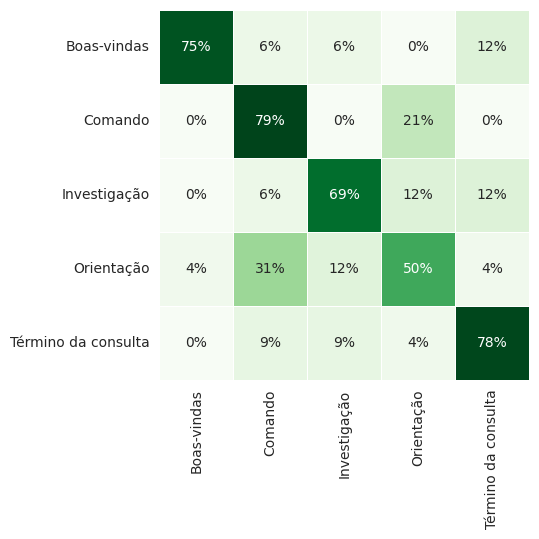

In [25]:
# Plot Matriz de confusão
matriz_confusao(y_test,y_pred)

#### **Resumo**
---

Conclusões após avaliação:
- Acurácia = 69%
- ROC_AUC = 81%
- F1-Score (média ponderada) ficou em 70%

Mesmo com a utilização do GridSearchCV não conseguimos melhorar nosso modelo inicial, pelo contrário, perdemos 2% de acurácia.

Vamos conferir o desempenho do nosso modelo inicial em dados de validação:



### **Avaliação | Dados de validação**
---



Agora que conseguimos gerar um novo modelo com otimização de hiperparâmetros, vamos submeter esse modelo em dados de teste:

#### **Preparação dos dados**
---

Vamos começar importando e preparando nossos dados:

In [54]:
df_val = pd.read_csv('Dados_validacao_comandos.csv')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Texto          100 non-null    object
 1   Classificacao  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [55]:
# Criando função que vai tratar nosso texto
def tratar_texto(texto):
    # Remover acentos
    texto_sem_acentos = unidecode(texto)

    # Remover pontuações
    texto_sem_pontuacoes = texto_sem_acentos.translate(str.maketrans("", "", string.punctuation))

    # Converter para letras minúsculas
    texto_tratado = texto_sem_pontuacoes.lower()

    return texto_tratado

# Limpeza e tratamento de dados
df_val["Texto"] = df_val.Texto.apply(tratar_texto).astype(str)

#### **Previsões**
---

In [56]:
# Criando coluna de 'Previsao' no dataset de validação
new_texts_transformed = vectorizer.transform(df_val['Texto'])
df_val['Previsao'] = model.predict(new_texts_transformed)

In [57]:
# Criando a coluna 'Resultado' com base nas condições
df_val['Resultado'] = ['Ok' if s == p else 'Verificar'
                             for s, p in zip(df_val['Classificacao'], df_val['Previsao'])]

In [ ]:
# Download das previsões
#df_val.to_csv('PrevisoesModeloDecisionTree.csv', index=False)

#### **Acurácia**
---

In [58]:
# Acurácia
acuracia = accuracy_score(df_val['Classificacao'], df_val['Previsao'])
print("Acurácia do modelo nos dados de validação: %.2f%%" % (acuracia * 100))

Acurácia do modelo nos dados de validação: 40.00%


Podemos observar que a acurácia do modelo no conjunto de validação foi de 40%, enquanto nos dados de teste foi de 71%. Esses resultados indicam que o modelo apresenta overfiting ou o ChatGPT rotulou muitos dados errados de validação.

## **Conclusão**
---

Através deste estudo, quis trazer a criação de um modelo de machine learning, passando por processos de tratamentos de dados, modelagem, otimização, avaliação e por fim a submissão do nosso modelo em dados de teste, a fim de deixar o entendimento mais transparente e direto.

Obviamente, como todos os estudos, este não é uma exceção e poderá ser sempre refinado e sempre estará aberto para novas ideias, feedbacks e ferramentas a serem implementadas.

Nessa etapa testamos mais um algoritmo para nosso sistema de classificação de texto do usuário. Fizemos 2 versões com o algoritmo Decision Tree (v1.0; v1.1) e testamos diversas configurações/modificações possíveis no modelo.

Resumindo cada versão e resultados em tópicos temos o seguinte:

**v1.0**
- Sem hiperparâmetros + TF-IDF
- Acurácia = 71%
- ROC_AUC = 82%
- F1-score = 71%

**v1.1**
- Otimização de Hiperparâmetros + TF-IDF
- Acurácia = 69%
- ROC_AUC = 81%
- F1-score = 70%
- Acurácia dados de validação = 40%